# A look into the habits of NYC Citibike riders

## Some Questions I Asked:
I wanted to use the data to build up a picture of who uses citibike, and the patterns of how they use it. Toward this end, I asked the following questions:
- Who is riding?
- How many people are riding?
- When do people ride?
- Are these trends changing over time?


In [1]:
# import libraries and connect to database
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
con = sqlite3.connect("data/citibike_database.db3")

### Who is riding?
- The majority of rides are taken by 'subscribers', as opposed to 'customers'
- The majority of rides are taken by males
- The median age of riders is 38 (note this is not of unqiue subscribers, rather this is weighted by # rides)

### User type

In [2]:
# usertype
df_user = pd.read_sql_query('SELECT usertype,count(*) as N FROM rides WHERE usertype != "None" GROUP BY usertype',con)
df_user.head()

,usertype,N
0,Customer,4372550
1,Subscriber,34723683


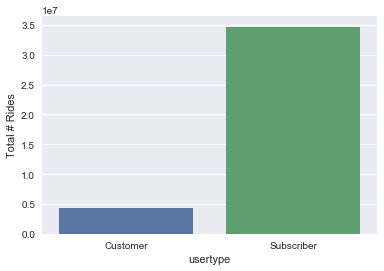

In [3]:
sns.barplot(df_user.usertype,df_user.N);
plt.ylabel('Total # Rides');

### Gender

In [4]:
# gender
df_gen = pd.read_sql_query('SELECT gender,count(*) as N FROM rides GROUP BY gender',con)
df_gen

,gender,N
0,0,4524854
1,1,26467273
2,2,8155886


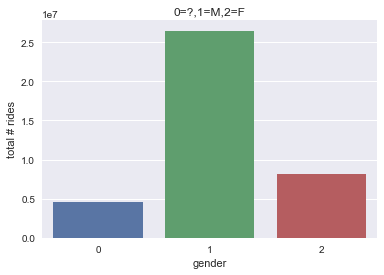

In [5]:
df_gen.gender = df_gen.gender.astype('int64')
#df_gen.info()
sns.barplot(df_gen.gender, df_gen.N);
plt.title('0=?,1=M,2=F');
plt.ylabel('total # rides');

### Age

In [6]:
# age ( exclude those >100 )
query = 'SELECT birth_year FROM rides WHERE birth_year != "None" AND birth_year != "\\N"  AND birth_year>1917 '
df_age = pd.read_sql_query(query,con)
#df_age.head()

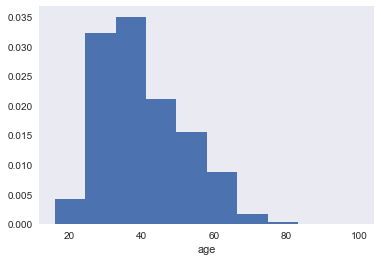

In [7]:
df_age.birth_year = df_age.birth_year.astype('float64')
df_age['age']=2017-df_age.birth_year
plt.hist(df_age.age,normed=True);
plt.xlabel('age')
plt.grid();

In [8]:
df_age.describe()

,birth_year,age
count,3.466429e+07,3.466429e+07
mean,1.976821e+03,4.017932e+01
std,1.144880e+01,1.144880e+01
min,1.917000e+03,1.600000e+01
25%,1.969000e+03,3.100000e+01
50%,1.979000e+03,3.800000e+01
75%,1.986000e+03,4.800000e+01
max,2.001000e+03,1.000000e+02


### How many rides do they take?
- The number of rides has increased each year, from about 8M in 2014 to almost 14M in 2016. 
- The number stations and bikes has also increased during that period.
- Part of the increase in rides could be due to more users, but there isn't a way to identify unique users in the data.

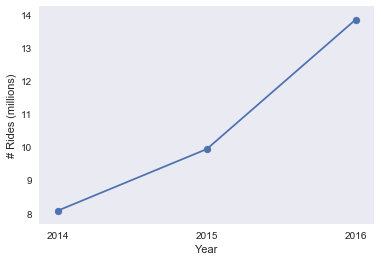

In [9]:
df = pd.read_sql_query("SELECT year,count(*) as num_rides FROM rides WHERE year IN (2014,2015,2016) GROUP BY year",con)
#df
df.year = df.year.astype('int')
plt.plot(df.year,df.num_rides/1e6)
plt.scatter(df.year,df.num_rides/1e6)
plt.grid();
plt.gca().set_xticks([2014,2015,2016]);
plt.xlabel('Year')
plt.ylabel('# Rides (millions)');

In [10]:
# for each month
query = "SELECT year,month,count(*) as N FROM rides WHERE year IN (2014,2015,2016) GROUP BY year,month "

df_rides = pd.read_sql_query(query,con)
df_rides.head()

,year,month,N
0,2014,1,300400
1,2014,2,224736
2,2014,3,439117
3,2014,4,670780
4,2014,5,866117


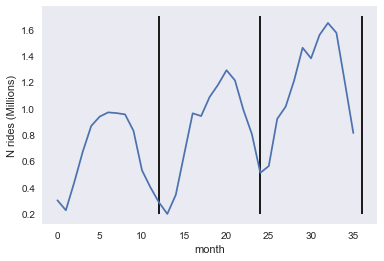

In [11]:
plt.plot(df_rides.N/1e6)
plt.xlabel('month');
plt.ylabel('N rides (Millions)');
plt.vlines([12,24,36],0.2,1.7)
plt.grid();

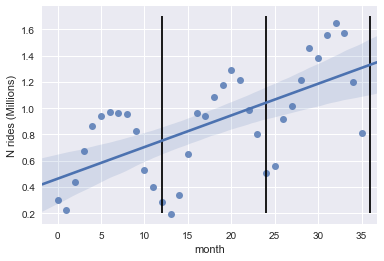

In [12]:
x=np.array(range(0,len(df_rides.N)))
sns.regplot(x,df_rides.N/1e6)
plt.xlabel('month');
plt.ylabel('N rides (Millions)');
plt.vlines([12,24,36],0.2,1.7);

Is this because more stations or bikes were added?

In [13]:
# get number of unique stations each month 
query = "SELECT year,month,count(distinct start_station_id) as N FROM rides WHERE year IN (2014,2015,2016) GROUP BY year,month"
df_sta = pd.read_sql_query(query,con)
df_sta.head()

,year,month,N
0,2014,1,329
1,2014,2,329
2,2014,3,331
3,2014,4,329
4,2014,5,328


In [14]:
# calculate # of unique bikes each month
query = 'SELECT year,month,COUNT(DISTINCT bikeid) as N FROM rides WHERE year IN (2014,2015,2016) GROUP BY year,month'
df_bikes = pd.read_sql_query(query,con)
df_bikes.head()

,year,month,N
0,2014,1,6354
1,2014,2,5699
2,2014,3,6298
3,2014,4,6532
4,2014,5,6186


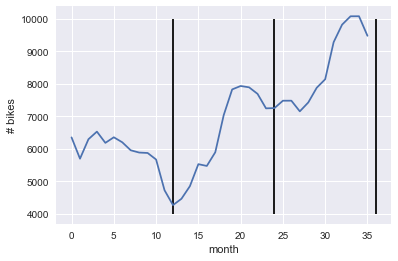

In [15]:
plt.plot(df_bikes.N)
plt.xlabel('month')
plt.ylabel('# bikes')
plt.vlines([12,24,36],4e3,10e3);

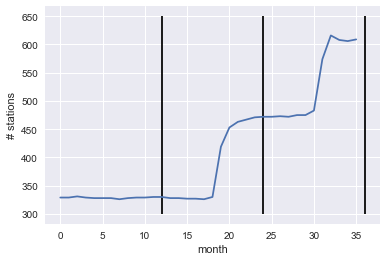

In [16]:
plt.plot(df_sta.N)
plt.xlabel('month')
plt.ylabel('# stations')
plt.vlines([12,24,36],300,650);

As expected, the number of bikes in the system is highly correlated w/ the number of stations.

(0.9237945802279236, 9.768773816901752e-16)

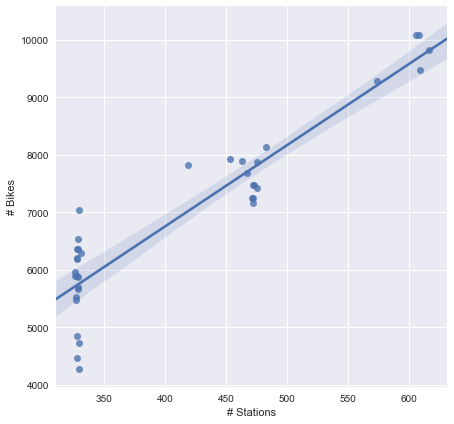

In [17]:
#sns.jointplot(df_sta.N,df_bikes.N)
#fig,ax = plt.subplots()
plt.figure(figsize=(7,7))
sns.regplot(df_sta.N,df_bikes.N)
plt.xlabel('# Stations');
plt.ylabel('# Bikes');
import scipy.stats as stats
stats.pearsonr(df_sta.N,df_bikes.N)

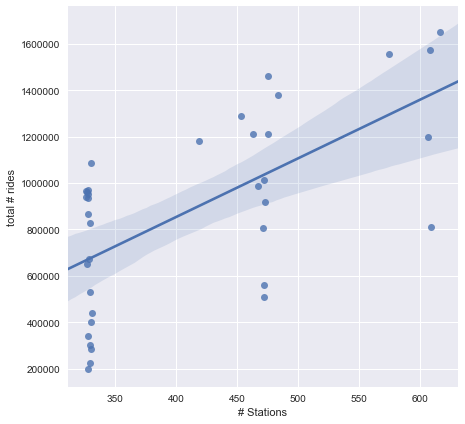

In [18]:
plt.figure(figsize=(7,7))
sns.regplot(df_sta.N,df_rides.N,x_jitter=.05)
plt.xlabel('# Stations')
plt.ylabel('total # rides');

### When do people ride?
- They ride more in the summer/early fall
- They ride more during the week than on weekends
- During the week, they rides during rush hour.
- On weekends, they sleep in and ride throughout the day

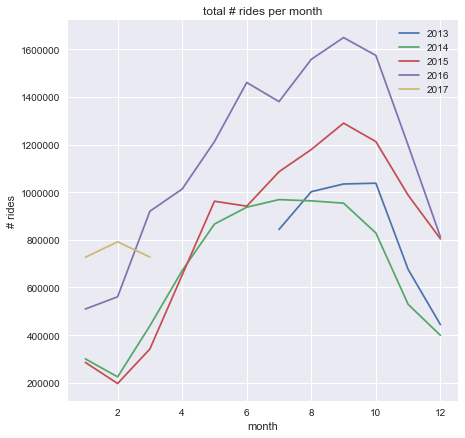

In [19]:
# total rides per month, each year
# count rides per month for one year
years = [2013,2014,2015,2016,2017]
plt.figure(figsize=(7,7))
for year in years:
    df = pd.read_sql_query("SELECT year,month,count(*) as num_rides FROM rides WHERE year=? GROUP BY month", con,params=[year])
    plt.plot(df.month, df.num_rides, label=str(year))
    #plt.scatter(df.month, df.num_rides)

#plt.grid()
plt.xlabel('month')
plt.ylabel('# rides')
plt.legend();
plt.title('total # rides per month');

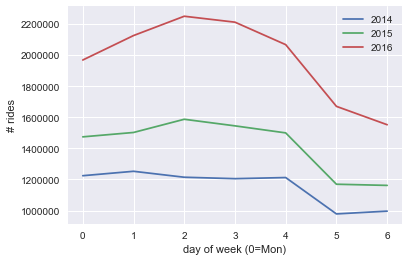

In [20]:
# For all comnplete years
# difference in magnitudes; maybe plot pdf instead?
years = [2014, 2015, 2016]
query = "SELECT year,wkday,count(*) as num_rides FROM rides WHERE year=? GROUP BY wkday"

for year in years:
    df_wkday = pd.read_sql_query(query, con, params=[year] )
    plt.plot(df_wkday.wkday,df_wkday.num_rides, label=str(year) )

#plt.grid()
plt.xlabel('day of week (0=Mon)')
plt.ylabel('# rides')
#plt.title(
plt.legend();

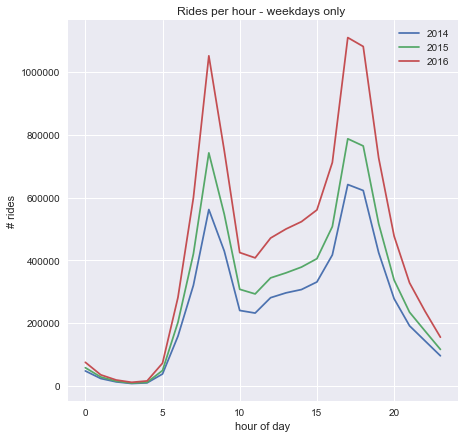

In [21]:
# hour of day - weekdays
years = [2014, 2015, 2016]
query = ('SELECT hour,count(*) as num_rides FROM rides WHERE year=? AND wkday<5 GROUP BY hour')

plt.figure(figsize=(7,7))
for year in years:
    df_hr = pd.read_sql_query(query, con, params=[year])
    plt.plot(df_hr.hour, df_hr.num_rides, label=str(year))

#plt.grid()
plt.xlabel('hour of day')
plt.ylabel('# rides')
plt.title('Rides per hour - weekdays only ')
plt.legend();

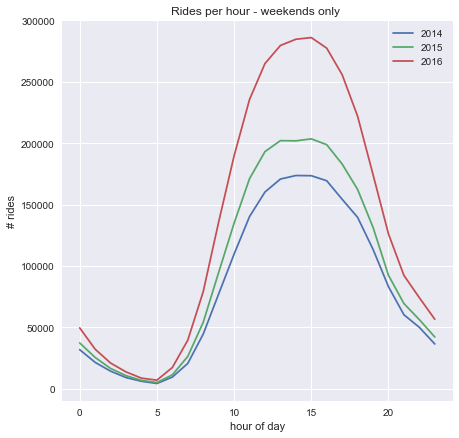

In [22]:
# hour of day - weekends

years = [2014, 2015, 2016]
query = ('SELECT hour,count(*) as num_rides FROM rides WHERE year=? AND wkday>4 GROUP BY hour')

plt.figure(figsize=(7,7))
for year in years:
    df_hr = pd.read_sql_query(query, con, params=[year])
    plt.plot(df_hr.hour, df_hr.num_rides, label=str(year))

#plt.grid()
plt.xlabel('hour of day')
plt.ylabel('# rides')
plt.title('Rides per hour - weekends only ')
plt.legend();

## Conclusions
- The majority of Citibke riders are male subscribers. 
- Citibike age: middle 50% between 31 and 48
- The total number of rides has a strong seasonal cycle, and also a postiive trend from 2014-2016.
- Part of that is due to an increase in the number of stations and bikes. 
- During the week, most rides are taken during rush-hour. Some of the most used stations are near transit centers like Penn Station, Grand Central etc.
- On weekends, rides are spread throughout the day. Some of the most used stations are near Central Park.
